Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 1, 5)              145       
                                                                 
 gru (GRU)                   (None, 1, 10)             510       
                                                                 
 dropout (Dropout)           (None, 1, 10)             0         
                                                                 
 gru_1 (GRU)                 (None, 5)                 255       
                                                                 
 dropout_1 (Dropout)         (None, 5)                 0         
                                                      

ValueError: ignored

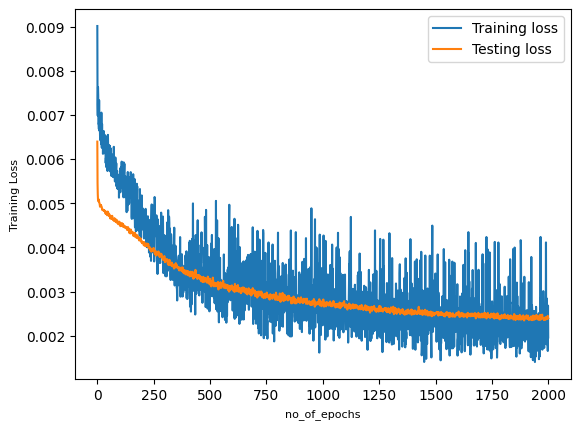

In [ ]:
import numpy as np
import pandas as pd
from math import sqrt

from matplotlib import pyplot
from pandas import read_csv

from pandas import DataFrame
from pandas import concat

import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
!pip install hydroeval
!pip install SGD


from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pywt
np.random.seed(2020)
from keras import regularizers, optimizers
from keras.models import Sequential, load_model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, LSTM, Bidirectional, BatchNormalization
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
from keras.layers.core import Dense, Activation
from keras.regularizers import l1_l2, l2
from numpy import array
import warnings

import matplotlib.pyplot as plt
from keras import optimizers

from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import plotly.graph_objs as go

df = pd.read_csv('final.csv')
df.head()

cols=list(df)[2:9]
data=df[cols].astype(float)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data= scaler.fit_transform(data)

#converts col into different array
Qa,Qbi,Qs,Qg,Qr,Qrm,Qb =scaled_data.T

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
  #n_vars = 1 if type(data) is list else data.shape[1]
  df = DataFrame(data)
  cols, names = list(), list()
# input sequence (t-n, ... t-1)
  for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
    names += [('var(t-%d)' % (i))] #for j in range(n_vars)]
# forecast sequence (t, t+1, ... t+n)
  for i in range(0, n_out):
    cols.append(df.shift(-i))
    if i == 0:
      names += [('var(t)')] #for j in range(n_vars)]
    else:
      names += [('var(t+%d)' % (i))] #for j in range(n_vars)]
# put it all together
  agg = concat(cols, axis=1)
  agg.columns = names
# drop rows with NaN values
  if dropnan:
    agg.dropna(inplace=True)
  return agg
for i in range(1,32,2):
    #Is = series_to_supervised(I,4,2)
    #Rs = series_to_supervised(R,i,1)
    Qas = series_to_supervised(Qa,i,1)
    Qbis= series_to_supervised(Qbi,i,1)
    Qss = series_to_supervised(Qs,i,1)
    Qgs = series_to_supervised(Qg,i,1)
    Qrs = series_to_supervised(Qr,i,1)
    Qrms = series_to_supervised(Qrm,i,1)
    Qbs = series_to_supervised(Qb,i,2)
    #Rs = series_to_supervised(R,1,1)

    dfs=[Qas,Qbis,Qss,Qgs,Qrs,Qrms,Qbs]
    Input=pd.concat(dfs,axis=1,keys=range(1,len(dfs)+1))
    Input.columns = Input.columns.map('{0[1]}{0[0]}'.format)
    Input = Input.iloc[i-0:] #change iloc only if u cange lag days
    Input = Input.drop(Input.index[-1:])

    Input

    y=Input[Input.columns[Input.columns.isin(['var(t+1)7'])]]

    y

    x=Input.drop(['var(t+1)7'],axis=1)

    x

    x_train=x[:456]
    x_val=x[456:639]
    x_test=x[639:]
    y_train=y[:456]
    y_val=y[456:639]
    y_test=y[639:]

    x_train.shape,x_test.shape,y_train.shape,y_test.shape
    x_val.shape,y_val.shape

    #converting dataframe to array to reshape in next step
    x_train=x_train.values
    y_train=y_train.values
    x_test=x_test.values
    y_test=y_test.values
    x_val=x_val.values
    y_val=y_val.values

    #reshape into 3-D cz model cannot perform in 2-D
    x_train = x_train.reshape((x_train.shape[0],1,x_train.shape[1]))
    x_val = x_val.reshape((x_val.shape[0],1,x_val.shape[1]))
    x_test = x_test.reshape((x_test.shape[0],1,x_test.shape[1]))

    x_train.shape

    from keras.layers import Dense, Flatten, Dropout, MaxPooling1D, TimeDistributed, LSTM, BatchNormalization, Input, concatenate, Conv1D


    model=Sequential()
    model.add(Conv1D(filters=5, kernel_size=2, padding = "same", strides = 1, activation = "relu",input_shape=(x_train.shape[1], x_train.shape[2])))
    # model.add(Conv1D(filters=50, kernel_size=2, padding = "same", strides = 1, activation = "relu"))
    #model.add(TimeDistributed(MaxPooling1D(2)))
    #model.add(TimeDistributed(Flatten()))
    model.add(GRU(units=10, return_sequences=True, input_shape=(x_train.shape[1],x_train.shape[2]), activation='relu'))
    model.add(Dropout(0.2))
    model.add(GRU(units=5, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    # Compiling the RNN
    model.compile(optimizer='SGD',loss='mse')
    model.summary()



    # Fitting to the training set
    history =model.fit(x_train.reshape(len(x_train), 1, x_train.shape[2], 1) ,y_train,validation_data=(x_val, y_val),epochs = 2000,batch_size=16,verbose=1)



    hist_df = pd.DataFrame(history.history)
    hist_df

    plt.plot(history.history['loss'],label='Training loss' )
    plt.plot(history.history['val_loss'], label='Testing loss')
    plt.xlabel('no_of_epochs', fontsize=8 )
    plt.ylabel('Training Loss', fontsize=8 )
    plt.legend()

    train_yp = model.predict(x_train.reshape(len(x_train),1, x_train.shape[2],1))
    val_yp = model.predict(x_val.reshape(len(x_val),1, x_val.shape[2], 1))
    test_yp = model.predict(x_test.reshape(len(x_test),1, x_test.shape[2],1))
    train_yp = model.predict(x_train)
    val_yp = model.predict(x_val)
    test_yp = model.predict(x_test)


    train_yp.shape

    test_yp.shape

    x_train.shape

    #reshape into the origional form (2-D)
    x_train = x_train.reshape((x_train.shape[0],x_train.shape[2]))
    x_val= x_val.reshape((x_val.shape[0],x_val.shape[2]))
    x_test= x_test.reshape((x_test.shape[0],x_test.shape[2]))

    #inverse_transform
    #1)x_train
    inv_x_train=pd.concat([pd.DataFrame(train_yp),pd.DataFrame(x_train[:, 6])], axis=1)
    rev_trans=scaler.inverse_transform(inv_x_train)
    y_train_prediction=rev_trans[:,0]

    #y_train
    inv_y_train=pd.concat([pd.DataFrame(y_train), pd.DataFrame(x_train[:, :6])], axis=1)
    rev_trans=scaler.inverse_transform(inv_y_train)
    y_train_Observed=rev_trans[:,0]

    #x_test
    inv_x_test=pd.concat([pd.DataFrame(test_yp), pd.DataFrame(x_train[:, :6])], axis=1)
    rev_trans=scaler.inverse_transform(inv_x_test)
    y_test_prediction=rev_trans[:,0]

    #y_test
    inv_y_test=pd.concat([pd.DataFrame(y_test), pd.DataFrame(x_train[:, :6])], axis=1)
    rev_trans=scaler.inverse_transform(inv_y_test)
    y_test_Observed=rev_trans[:,0]

    # x_val
    inv_x_val=pd.concat([pd.DataFrame(val_yp), pd.DataFrame(x_train[:, :6])], axis=1)
    rev_trans=scaler.inverse_transform(inv_x_val)
    y_val_prediction=rev_trans[:,0]

    #y_val
    inv_y_val=pd.concat([pd.DataFrame(y_val), pd.DataFrame(x_train[:, :6])], axis=1)
    rev_trans=scaler.inverse_transform(inv_y_val)
    y_val_Observed=rev_trans[:,0]


    y_train_pre=np.array(y_train_prediction)
    y_train_rev=np.array(y_train_Observed)
    l=np.array([y_train_prediction,y_train_Observed])
    dataset=pd.DataFrame(l)
    dataset=dataset.transpose()
    dataset.columns = ['y_train_prediction', 'y_train_Observed']

    dataset

    dataset[['y_train_prediction','y_train_Observed']].plot()

    from hydroeval import evaluator, nse

    NSE_train = evaluator(nse,y_train_prediction , y_train_Observed )
    print(NSE_train)

    #test
    y_test_pre=np.array(y_test_prediction)
    y_test_Observed=np.array(y_test_Observed)
    l=np.array([y_test_prediction,y_test_Observed])
    dataset_test=pd.DataFrame(l)
    dataset_test=dataset_test.transpose()
    dataset_test.columns = ['y_test_pre', 'y_test_Observed']
    dataset_test[['y_test_pre','y_test_Observed']].plot()

    NSE_test = evaluator(nse,y_test_pre , y_test_Observed )
    print(NSE_test)

    y_val_pre=np.array(y_val_prediction)
    y_val_Observed=np.array(y_val_Observed)
    l=np.array([y_val_prediction,y_val_Observed])
    dataset_val=pd.DataFrame(l)
    dataset_val=dataset_val.transpose()
    dataset_val.columns = ['y_val_pre', 'y_val_Observed']
    dataset_val[['y_val_pre','y_val_Observed']].plot()

    NSE_val = evaluator(nse,y_val_pre , y_val_Observed )
    print(NSE_val)

    from scipy.stats import pearsonr
    from sklearn.metrics import mean_absolute_error
    np.random.seed(2020)
    from hydroeval import evaluator,nse,kge,kgeprime,rmse,mare,pbias

    NSE_train = evaluator(nse,y_train_prediction , y_train_Observed )
    NSE_val = evaluator(nse,y_val_pre , y_val_Observed )
    NSE_test = evaluator(nse,y_test_pre , y_test_Observed )

    RMSE_Training =evaluator(rmse,y_train_prediction , y_train_Observed)
    RMSE_val = evaluator(rmse,y_val_pre, y_val_Observed)
    RMSE_Testing = evaluator(rmse,y_test_pre , y_test_Observed)


    MARE_Training =evaluator(mare,y_train_pre,y_train_Observed)
    MARE_val = evaluator(mare,y_val_pre, y_val_Observed)
    MARE_Testing = evaluator(mare,y_test_pre , y_test_Observed)


    PBIAS_Training =evaluator(pbias,y_train_pre ,y_train_Observed)
    PBIAS_val = evaluator(pbias,y_val_pre, y_val_Observed)
    PBIAS_Testing = evaluator(pbias,y_test_pre , y_test_Observed)


    # corr_train ,p_value_train = pearsonr(y_train_pre, y_train_Observed)
    # corr_test ,p_value_test = pearsonr(y_test_pre,  y_test_Observed)


    # mae_train = mean_absolute_error(y_train_Observed, y_train_pre)
    # mae_test = mean_absolute_error( y_test_Observed,y_test_pre)

    v_error_train = (np.sum(y_train_pre)-np.sum(y_train_Observed))/np.sum(y_train_Observed)
    v_error_val  = (np.sum(y_val_pre)-np.sum(y_val_Observed))/np.sum(y_val_Observed)
    v_error_test  = (np.sum(y_test_pre)-np.sum(y_test_Observed))/np.sum(y_test_Observed)

    results=[NSE_train,NSE_val,NSE_test,RMSE_Training,RMSE_val,RMSE_Testing, MARE_Training,MARE_val,MARE_Testing, PBIAS_Training,PBIAS_val,PBIAS_Testing,v_error_train,v_error_val,v_error_test]
    l=np.array([results])
    res=pd.DataFrame(l).transpose()
    res

    res.to_csv(str(i)+'cnn_gru.csv')

